# Construct school interaction networks from basic school statistics

In [403]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Helper functions for graph composition

### Distribution of classes to floors

In [404]:
def get_floor_distribution(N_floors, N_classes):
    floors = {i:[] for i in range(N_floors)} # starts with 0 (ground floor)
    classes = list(range(1, N_classes + 1))
    classes_per_floor = int(N_classes / N_floors) 
    
    # easiest case: the number of classes is divisible by the number of floors
    if N_classes % N_floors == 0:
        for i, floor in enumerate(range(N_floors)):
            floors[floor] = classes[i * classes_per_floor: \
                                    i * classes_per_floor + classes_per_floor]
        
    # if there are leftover classes: assign them one-by-one to the existing 
    # floors, starting with the lowest
    else:
        leftover_classes = N_classes % N_floors
        classes_per_floor += 1
        for i, floor in enumerate(range(N_floors)):
            if i < leftover_classes:
                floors[floor] = classes[i * classes_per_floor: \
                                        i * classes_per_floor + classes_per_floor]
            # hooray, index magic!
            else:
                floors[floor] = classes[leftover_classes * classes_per_floor + (i - leftover_classes) * (classes_per_floor - 1):
                                        leftover_classes * (classes_per_floor) + (i - leftover_classes) * (classes_per_floor - 1) + classes_per_floor - 1]
                
    # invert dict for easier use
    floors_inv = {}
    for floor, classes in floors.items():
        for c in classes:
            floors_inv.update({c:floor})
    
    return floors, floors_inv

### Neighbourhood relations between classes on the same floor

In [405]:
def get_neighbour_classes(floors_inv, N_close_classes):
    classes = list(range(1, N_classes + 1))
    N_floors = len(floors)
    classes_per_floor = int(N_classes / N_floors) 
    assert N_close_classes <= classes_per_floor - 1, 'not enough classes per floor to satisfy number of neighbouring classes!'
    
    # pick the neighbouring classes from the list of classes on the same floor
    # NOTE: this does NOT lead to a uniform distribution of neighbouring classes
    # for every class. There are more central classes that will have more 
    # neighbours than other classes
    class_neighbours = {i:[] for i in classes}
    for floor in floors.keys():
        circular_class_list = floors[floor] * 2
        # iterate over all classes on a given floor
        for i,c in enumerate(floors[floor]):
            neighbours = []
            for j in range(1, int(N_close_classes / 2) + 1):
                neighbours.append(circular_class_list[i - j])
                neighbours.append(circular_class_list[i + j])
            neighbours.sort()
            class_neighbours[c] = neighbours
            
    return class_neighbours

### Distribution of age brackets over classes

In [406]:
def get_age_distribution(school_type, N_classes):
    classes = list(range(1, N_classes + 1))
    age_brackets = school_types[school_type]
    N_age_brackets = len(age_brackets)
    classes_per_age_bracket = int(N_classes / N_age_brackets)
    
    assert N_age_brackets <= N_classes, 'not enough classes to accommodate all age brackets in this school type!'
    
    age_bracket_map = {i:[] for i in age_brackets}
    
    # easiest case: the number of classes is divisible by the number of floors
    if N_classes % N_age_brackets == 0:
        for i, age_bracket in enumerate(age_brackets):
            age_bracket_map[age_bracket] = classes[i * classes_per_age_bracket: \
                                    i * classes_per_age_bracket + classes_per_age_bracket]
        
    # if there are leftover classes: assign them one-by-one to the existing 
    # age brackets, starting with the lowest
    else:
        leftover_classes = N_classes % N_age_brackets
        print(leftover_classes)
        classes_per_age_bracket += 1
        for i, age_bracket in enumerate(age_brackets):
            if i < leftover_classes:
                age_bracket_map[age_bracket] = classes[i * classes_per_age_bracket: \
                                        i * classes_per_age_bracket + classes_per_age_bracket]
            # hooray, index magic!
            else:
                age_bracket_map[age_bracket] = classes[leftover_classes * classes_per_age_bracket + (i - leftover_classes) * (classes_per_age_bracket - 1):
                                        leftover_classes * (classes_per_age_bracket) + (i - leftover_classes) * (classes_per_age_bracket - 1) + classes_per_age_bracket - 1]

    print(age_bracket_map)
    
    # invert dict for easier use
    age_bracket_map_inv = {}
    for age_bracket, classes in age_bracket_map.items():
        for c in classes:
            age_bracket_map_inv.update({c:age_bracket})            
                
    return age_bracket_map_inv

### Node and edge creating functions for classes, families and teachers

In [407]:
# generate the nodes for students in a class and contacts between all students
# (complete graph)
def generate_class(G, class_size, student_counter, class_counter, floors, \
                   age_bracket_map):
    
    student_age = age_bracket_map[class_counter]
    class_floor = floors[class_counter]
    
    student_nodes = ['s{}'.format(i) for i in range(student_counter, \
                                student_counter + class_size )]
    G.add_nodes_from(student_nodes)
    nx.set_node_attributes(G, \
        {s:{'type':'student', 'unit':'class_{}'.format(class_counter), 
            'floor':class_floor, 'age':student_age} for s in student_nodes})
    
    for s1 in student_nodes:
        for s2 in student_nodes:
            if s1 != s2:
                G.add_edge(s1, s2, link_type='student_student',
                           contact_type='intermediate')
    return G, student_counter + class_size, class_counter + 1

# generate a random number of family members (based on household size 
# distributions) for every student. All family members have close contacts to
# each other and the student
def generate_family(G, student_ID, family_counter):
    # draw random number of family members
    N_family_members = np.random.choice(list(family_sizes.keys()), 1,
              p=[family_sizes[s] for s in family_sizes.keys()])[0]
    
    # create family nodes and add them to the graph
    family_nodes = ['f{}'.format(i) for i in \
                range(family_counter, family_counter + N_family_members - 1)]
    G.add_nodes_from(family_nodes)
    nx.set_node_attributes(G, \
        {f:{'type':'family_member', 'unit':'family'} for f in family_nodes})
    
    # all family members have contact to each other
    for f1 in family_nodes:
        for f2 in family_nodes: 
            if f1 != f2:
                G.add_edge(f1, f2, link_type='family_family', 
                           contact_type='close')
        # all family members also have contact to the student they belong to
        G.add_edge(f1, student_ID, link_type ='student_family',
                   contact_type='close')
        
    return G, family_counter + N_family_members
        
# generate a number of teachers which each have contact to all other teachers
# and contact to all students in a random selection of N_classes_taught classes
def generate_teachers(G, N_teachers, N_classes, N_classes_taught):
    teacher_nodes = ['t{}'.format(i) for i in range(1, N_teachers + 1)]
    G.add_nodes_from(teacher_nodes)
    nx.set_node_attributes(G, \
        {t:{'type':'teacher', 'unit':'faculty_room'} for t in teacher_nodes})
    
    # all teachers have contact to each other
    for t1 in teacher_nodes:
        for t2 in teacher_nodes:
            if t1 != t2:
                G.add_edge(t1, t2, link_type='teacher_teacher', 
                           contact_type='intermediate')
    
    # assign each teacher to 4 classes they teach 
    schedule = {t:[] for t in teacher_nodes}
    circular_class_list = list(range(1, N_classes + 1)) * 2
    for i, t in enumerate(teacher_nodes):
        schedule[t] = circular_class_list[i % N_classes:\
                                          i % N_classes + N_classes_taught]
        
    # generate the contact network between the teachers and the students in the
    # classes they teach
    for t in teacher_nodes:
        for c in schedule[t]:
            students_in_class = [x for x,y in G.nodes(data=True) if \
                                (y['type'] == 'student') and \
                                 y['unit'] == 'class_{}'.format(c)]
            
            for s in students_in_class:
                G.add_edge(t, s, link_type='student_teacher', 
                           contact_type='intermediate')
                
    return G, schedule

# add a number of random contacs between students of neighboring classes
def add_cross_class_contacts(G, cross_class_contacts, class_neighbours):
    
    for c in range(1, N_classes + 1):
        students_in_class = [x for x,y in G.nodes(data=True) if \
                    (y['type'] == 'student') \
                             and y['unit'] == 'class_{}'.format(c)]
        
        for neighbour_class in class_neighbours[c]:
            students_in_neighbour_class = [x for x,y in G.nodes(data=True) if \
                    (y['type'] == 'student') and \
                     y['unit'] == 'class_{}'.format(neighbour_class)]

            neighbour_contacts = np.random.choice(students_in_neighbour_class,
                                        X_class_contacts, replace=False)
            class_contacts = np.random.choice(students_in_class, 
                                        X_class_contacts, replace=False)

            for i in range(X_class_contacts):
                if not G.has_edge(neighbour_contacts[i], class_contacts[i]):
                    G.add_edge(neighbour_contacts[i], class_contacts[i], 
                           link_type='student_student', contact_type='far')
            
    return G

## Descriptive school constants

Descriptive school statistics are inspired by [data](https://www.bmbwf.gv.at/Themen/schule/schulsystem/gd.html) about Austrian schools from 2018.

In [408]:
# different age structures in Austrian school types
school_types = {'volksschule':[6, 7, 8, 9],
                'gymnasium':[10, 11, 12, 13, 14, 15, 16, 17],
                'unterstufe':[10, 11, 12, 13],
                'oberstufe':[14, 15, 16, 17]}

# wild guesses about the proportion of sizes of house holds with children in Austria
family_sizes = {2:0.1, 3:0.25, 4:0.35, 5:0.2, 6:0.1}

In [409]:
school_name = 'test_gymnasium'

# number of students in a class
class_size = 20
# number of classes in a school
N_classes = 10
# number of teachers in a school
N_teachers = N_classes * 2
# number of teaching units / day
N_hours = 8
# number of classes a teacher is in contact with
N_classes_taught = int(N_hours / 2)

## architecture
N_floors = 2
N_close_classes = 2 # needs to be even

# school type
school_type = 'volksschule'
    
# number of inter-class contacts for neighboring classes:
# as each class has cross_class_contacts to each of it's N_close_classes 
# neighbours, the total number of inter-class contacts between each pair of 
# neighboring classes is X*Y
cross_class_contacts = 2

## Compose a sample graph

In [410]:
# distribution of classes over the available floors and neighborhood relations
# of classes based on spatial proximity
floors, floors_inv = get_floor_distribution(N_floors, N_classes)
print('floor distribution: ', floors)
class_neighbours = get_neighbour_classes(floors, N_close_classes)
print()
print('neighbourhood relations: ', class_neighbours)
age_bracket_map = get_age_distribution('volksschule', N_classes)
print()
print('age bracket distribution: ', age_bracket_map)

floor distribution:  {0: [1, 2, 3, 4, 5], 1: [6, 7, 8, 9, 10]}

neighbourhood relations:  {1: [2, 5], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [1, 4], 6: [7, 10], 7: [6, 8], 8: [7, 9], 9: [8, 10], 10: [6, 9]}
2
{6: [1, 2, 3], 7: [4, 5, 6], 8: [7, 8], 9: [9, 10]}

age bracket distribution:  {1: 6, 2: 6, 3: 6, 4: 7, 5: 7, 6: 7, 7: 8, 8: 8, 9: 9, 10: 9}


In [411]:
G = nx.Graph()

# add students
student_counter = 1
for c in range(1, N_classes + 1):
    G, student_counter, class_counter = generate_class(G, class_size, \
                            student_counter, c, floors_inv, age_bracket_map)

# add teachers
G, schedule = generate_teachers(G, N_teachers, N_classes, N_classes_taught)

# add family members
family_counter = 1
students = ['s{}'.format(i) for i in range(1, N_classes * class_size + 1)]
for s in students:
    G, family_counter = generate_family(G, s, family_counter)
    
# create inter-class contacts
G = add_cross_class_contacts(G, cross_class_contacts, class_neighbours)

nx.readwrite.gpickle.write_gpickle(G, '../data/school/{}.gpickle'.format(school_name))

### Save node-list

In [412]:
node_list = pd.DataFrame()
for n in G.nodes(data=True):
    if n[1]['type'] == 'student':
        location = n[1]['unit']
    elif n[1]['type'] == 'teacher':
        location = 'faculty_room'
    else:
        student = [item for sublist in G.edges('f1') for item in sublist \
                   if item.startswith('s')][0]
        location = 'home_{}'.format(student)
    node_list = node_list.append({'ID':n[0],
                                  'type':n[1]['type'],
                                  'location':location}, ignore_index=True)

node_list.to_csv('../data/school/{}_nodelist.csv'.format(school_name), index=False)
node_list.head(3)

,ID,location,type
0,s1,class_1,student
1,s2,class_1,student
2,s3,class_1,student


### Teacher's schedule

In [413]:
teachers = ['t{}'.format(i) for i in range(1, N_teachers + 1)]
cols = ['teacher']
cols.extend(['class_{}'.format(i) for i in range(1, N_classes + 1)])
schedule_df = pd.DataFrame(columns=cols)
schedule_df['teacher'] = teachers
schedule_df.index = schedule_df['teacher']
schedule_df = schedule_df.drop(columns=['teacher'])

# every teacher teachers a class every second hour. The first half of teachers
# starts in the first hour, the second half of teachers starts in the second hour
for t in teachers[0:int(N_teachers/2)]:
    for i in range(0, 4):
        schedule_df.loc[t, 'class_{}'.format(schedule[t][i])] = i * 2 + 1
        
for t in teachers[int(N_teachers/2):]:
    for i in range(0, 4):
        schedule_df.loc[t, 'class_{}'.format(schedule[t][i])] = i * 2 + 2

# increment all hours after 4 by one to make room for the lunch break in the 
# 5th hour
for c in schedule_df.columns:
    schedule_df[c] = schedule_df[c].apply(lambda x: x + 1 if x > 4 else x)
schedule_df.to_csv('../data/school/{}_schedule.csv'.format(school_name))
schedule_df

,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10
teacher,,,,,,,,,,
t1,1.0,3.0,6.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
t2,NaN,1.0,3.0,6.0,8.0,NaN,NaN,NaN,NaN,NaN
t3,NaN,NaN,1.0,3.0,6.0,8.0,NaN,NaN,NaN,NaN
t4,NaN,NaN,NaN,1.0,3.0,6.0,8.0,NaN,NaN,NaN
t5,NaN,NaN,NaN,NaN,1.0,3.0,6.0,8.0,NaN,NaN
t6,NaN,NaN,NaN,NaN,NaN,1.0,3.0,6.0,8.0,NaN
t7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,6.0,8.0
t8,8.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,6.0
t9,6.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0


## Visualization

### Create fixed node positions for students and teachers

In [414]:
fixed_pos = {}
class_width = 0.2
class_x_sep = 0.2/3
class_height = 0.2
N_horizontal = 5
N_vertical = 4

# bottom row of classes
student_counter = 1
for c in range(0, 4):
    for x in range(0, N_horizontal):
        for y in range(N_vertical):
            x_pos = class_width * c + x * class_width / N_horizontal + \
                c * class_x_sep
            y_pos = 0 + y * class_height / N_vertical
            fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
            student_counter += 1

# left middle class
for x in range(0, N_horizontal):
    for y in range(N_vertical):
        x_pos = 0 + x * class_width / N_horizontal
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
        student_counter += 1
        
# right middle class
for x in range(0, N_horizontal):
    for y in range(N_vertical):
        x_pos = class_width * 3 + x * class_width / N_horizontal + \
            3 * class_x_sep
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
        student_counter += 1

# top row of classes
for c in range(7, 11):
    for x in range(0, N_horizontal):
        for y in range(N_vertical):
            x_pos = class_width * (c-7) + x * class_width / N_horizontal +\
                (c - 7) * class_x_sep
            y_pos = 0.6 + y * class_height / N_vertical
            fixed_pos.update({'s{}'.format(student_counter):(x_pos, y_pos)})
            student_counter += 1
            
# teachers
teacher_counter = 1
for x in range(0, N_horizontal):
    for y in range(0, N_vertical):
        x_pos = class_width * 1.5 + x * class_width / N_horizontal + \
            1 * class_x_sep
        y_pos = 0.3 + y * class_height / N_vertical
        fixed_pos.update({'t{}'.format(teacher_counter):(x_pos, y_pos)})
        teacher_counter += 1

### Visualize the class

(-0.3, 1.3)

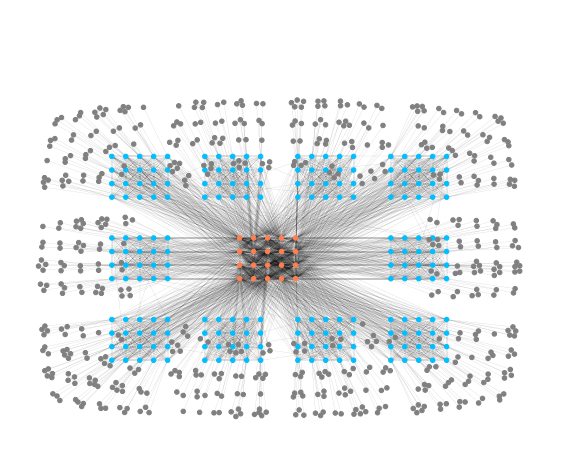

In [415]:
fig, ax = plt.subplots(figsize=(10, 8))
# generate random positions for family members (students & teachers are fixed)
pos = nx.spring_layout(G, pos=fixed_pos, fixed=fixed_pos.keys())
family_members = [x for x,y in G.nodes(data=True) if y['type'] == \
                  'family_member']

node_color = ['DeepSkyBlue'] * len(students)
node_color.extend(['Coral'] * N_teachers)
node_color.extend(['grey'] * len(family_members))

node_list = students[:]
teachers = ['t{}'.format(i) for i in range(1, N_teachers + 1)]
node_list.extend(teachers)
node_list.extend(family_members)

nx.draw(G, pos, node_size=20, ax=ax, width = 0.05, nodelist=node_list, \
       node_color = node_color)
ax.set_ylim(-0.3, 1.3)
ax.set_xlim(-0.3, 1.3)